In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib
import json
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten, Dropout
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten, Dropout, Bidirectional
from keras.layers import LSTM, Dropout,Activation, Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import *
import random
import copy

In [ ]:
def removeStopWords(lowerArg):
    i=0
    removed=[]
    for x in lowerArg:
        i+=1
        removed.append((' '.join([word for word in x.split() if word not in nltk.corpus.stopwords.words('english')])))
        
    return pd.Series(removed).astype(str)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Movie_Genre/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
df['Genre']=df['Genre'].replace('unknown',np.nan)
df=df.dropna(axis=0, subset=['Genre'])
print(df.tail())

       Release Year  ...                                               Plot
34877          2013  ...  Zeynep lost her job at weaving factory, and he...
34882          2017  ...  Two musicians, Salih and Gürkan, described the...
34883          2017  ...  Zafer, a sailor living with his mother Döndü i...
34884          2017  ...  The film centres around a young woman named Am...
34885          2017  ...  The writer Orhan Şahin returns to İstanbul aft...

[5 rows x 8 columns]


In [ ]:
print(len(df))
print(df.shape)
a=df['Genre'].value_counts()[:20]
b=a.keys().tolist()
print(b)
df=df[df.Genre.isin(b)]
df=df.reset_index(drop=True)

28803
(28803, 8)
['drama', 'comedy', 'horror', 'action', 'thriller', 'romance', 'western', 'crime', 'adventure', 'musical', 'crime drama', 'romantic comedy', 'science fiction', 'film noir', 'mystery', 'war', 'animation', 'comedy, drama', 'sci-fi', 'family']


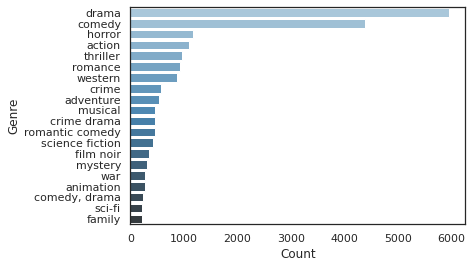

In [ ]:
import seaborn as sns
import matplotlib as plt
sns.set(style="white")
genre_to_count=pd.DataFrame({'Genre':a.index, 'Count':a.values})

sns.barplot(y="Genre", x="Count", data=genre_to_count,palette="Blues_d")

In [ ]:
##Limit to just comedies and Genres
genres=['drama','comedy','horror','action']
df=df[df['Genre'].isin(genres)]
df=df.reset_index()
df['GenreID']=df['Genre'].apply(lambda x: genres.index(x))

wordCount=df['Plot'].apply(lambda x: x.count(' '))
print("Mean number of words in synopses: ",int(wordCount.mean()))
print("Standard deviation number of words in synopses: ", int(wordCount.std()))
print('Number of Dramas: ',df['Genre'].value_counts()[0])
print('Number of Comedies: ',df['Genre'].value_counts()[1])
print('Number of horror: ',df['Genre'].value_counts()[2])
print('Number of action: ',df['Genre'].value_counts()[3])


Mean number of words in synopses:  359
Standard deviation number of words in synopses:  298
Number of Dramas:  5964
Number of Comedies:  4379
Number of horror:  1167
Number of action:  1098


Distribution of Synopsis Word Counts


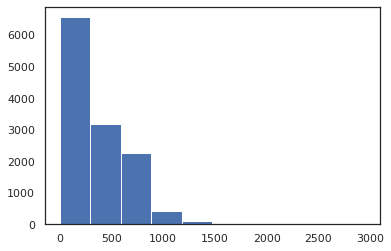

In [ ]:
matplotlib.pyplot.hist(wordCount)
print('Distribution of Synopsis Word Counts')

In [ ]:
synNumber=random.randint(1,1000)
print(df['Title'].loc[synNumber])
print(df['Genre'].loc[synNumber])
print(df['Plot'].loc[synNumber])

The Playhouse
comedy
The film is set up as a series of humorous tricks on the audience, with constant doubling, and in which things are rarely what they at first seem to be. It opens with Keaton attending a variety show. In this first sequence, Keaton plays beside him and remarks, "This fellow Keaton seems to be the whole show." This was a gibe at one of Keaton's contemporaries, Thomas Ince, who credited himself generously in his film productions.[1] In interviews with Kevin Brownlow,[2] Keaton claims he gave the director's credit to Cline mainly because he did not want to appear too Ince-like himself: "Having kidded things like that, I hesitated to put my own name on as a director and writer."
This elaborate trick-photography sequence turns out to be only a dream when Joe Roberts rouses Keaton from bed. The bedroom then turns out to be not a bedroom, but a set on a stage.
The second half of the film features Keaton's character falling for a girl who happens to be a twin. He has diffic

# Text processing and vectorization


In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
df['StemmedPlot']=df['Plot'].str.split().apply(lambda x: ' '.join([stemmer.stem(y) for y in x]))


Make the both datasets lower-case and remove stop words

In [ ]:


#Store Original Plot for later
df['OriginalPlot']=df['Plot']

lower=df['Plot'].str.lower()


Tokenize movie data and pad sequences to maximum length

In [ ]:
##Using non-stemmed
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df['Plot']))
sequences = tokenizer.texts_to_sequences(list(df['Plot']))
maxLen=np.max([len(sequence) for sequence in sequences])
print("Maximum Length: ",maxLen)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxLen)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)


Maximum Length:  2978
Found 93887 unique tokens.
Shape of data tensor: (12608, 2978)


Quick sanity check to make sure that the tokenizer worked properly

In [ ]:
##Sanity Check index is the word_index dictionary with keys reversed
sanityCheckIndex={v: k for k, v in tokenizer.word_index.items()}
print(sequences[500])
print(' '.join([sanityCheckIndex[wordIndex] for wordIndex in sequences[500]]))
print(data[500][0])
print(data[500][-1])
print(' '.join([sanityCheckIndex[wordIndex] for wordIndex in data[500] if wordIndex!=0 ]))

[3407, 1262, 4, 7624, 5, 1, 1077, 7107, 402, 1262, 6, 281, 4, 5675, 3, 15264, 66, 19, 26, 489, 7, 1, 7984, 21, 172, 222, 707, 36, 281, 1, 189, 66, 7, 6819, 28, 14, 211, 12, 10, 49, 7, 838, 15, 87, 24, 2419, 10, 286, 7, 204, 2, 39, 5, 8, 39771, 123, 14, 6, 109, 1092, 12, 6819, 6, 1, 209, 2, 36, 28, 26, 327, 125, 2, 1, 489, 2, 699, 126, 10770, 14, 178, 7, 67, 11, 13, 3, 28, 14, 168, 9, 6, 2, 36, 4186, 32, 5, 8, 87, 3, 118, 14, 167, 288, 2, 355, 13, 3, 82, 2, 6819, 11, 13]
anita morgan a descendant of the famous pirate henry morgan is living a carefree and careless life on an island in the caribbean but would much rather be living the same life in havana when she learns that her father in exchange for money has promised her hand in marriage to one of his swarthy friends she is more convinced that havana is the place to be when an american comes to the island to buy some pearls she falls in love with him and when she discovers he is to be tricked out of his money and killed she makes plans

Split the data into train and test sets.  Additionally, create separate training sets for training data enhanced with news data and training data consisting only of movie data

In [ ]:
seed=random.randint(1,1000)
X_train, X_test, y_train, y_test = train_test_split(data, df['GenreID'], test_size=0.2, random_state=seed)
testIndices=y_test.index
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

y_train_small=y_train.copy()
X_train_small=X_train.copy()

print("X Train  shape: ",X_train_small.shape)
print("Y train  shape: ",y_train_small.shape)
print("X test shape: ",X_test.shape)
print("Y test shape: ",y_test.shape)


X Train  shape:  (10086, 2978)
Y train  shape:  (10086, 4)
X test shape:  (2522, 2978)
Y test shape:  (2522, 4)


In [ ]:
a

drama              5964
comedy             4379
horror             1167
action             1098
thriller            966
romance             923
western             865
crime               568
adventure           526
musical             467
crime drama         464
romantic comedy     461
science fiction     418
film noir           345
mystery             310
war                 273
animation           264
comedy, drama       236
sci-fi              221
family              217
Name: Genre, dtype: int64

# 5. GloVE embeddings
Load the GloVE 6B 100d word embeddings in hopes that they will enhance the accuracy and training speed of the neural network models.

In [ ]:
embeddings={}
index=0
with open('/content/drive/MyDrive/Movie_Genre/glove.6B.100d.txt') as file:
    for embeddingLine in file:
        lineSplit=embeddingLine.split()
        coefs = np.asarray(lineSplit[1:], dtype='float32')
        embeddings[lineSplit[0]]=coefs
        index+=1



Map the GloVE embeddings to the data

In [ ]:
embeddings_matrix=np.zeros((len(word_index)+1,len(embeddings['a'])))
for word,i in word_index.items():
    if word in embeddings:
        embeddings_matrix[i]=embeddings[word]



Quick check to make sure that the embeddings matrix is right

In [ ]:
print('Word #2: ',sanityCheckIndex[2])
print('Index of him : ',word_index['him'])
print('Embbedding in embeddings list: ',embeddings['him'][:5])
print('Embedding in embeddings matrix: ',embeddings_matrix[2][:5])


Word #2:  to
Index of him :  13
Embbedding in embeddings list:  [ 0.042409 -0.52195   0.40389  -0.31683   0.015581]
Embedding in embeddings matrix:  [-0.18970001  0.050024    0.19084001 -0.049184   -0.089737  ]


In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            len(embeddings['a']),
                            weights=[embeddings_matrix],
                            input_length=maxLen,
                            trainable=False)
embedding_layerNoGlove = Embedding(len(word_index) + 1,
                            len(embeddings['a']),
                            weights=[embeddings_matrix],
                                   input_length=maxLen
                            )


In [ ]:
from keras import *
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
embeddingOnlyModel = Model(sequence_input, embedded_sequences)

print('Manual Embeddings Result: ',[list(embeddings[sanityCheckIndex[x]][:3]) if sanityCheckIndex[x] in embeddings else [0,0,0] for x in sequences[500] ][-5:])
##print(sequences[500])
##print([ sanityCheckIndex[l] for l in list(data[500]) if l>0 ])
##print([ sanityCheckIndex[l] for l in list(sequences[500]) if l>0 ])
print('Model Embeddings Result: ',embeddingOnlyModel.predict(np.array(data[500]).reshape(1,maxLen))[0,-5:,:3])
##print(embeddings_matrix[2][:5])


Manual Embeddings Result:  [[-0.078894, 0.4616, 0.57779], [-0.1897, 0.050024, 0.19084], [0.92962, -0.33633, -0.059828], [-0.43608, 0.39104, 0.51657], [0.042409, -0.52195, 0.40389]]
Model Embeddings Result:  [[-0.078894  0.4616    0.57779 ]
 [-0.1897    0.050024  0.19084 ]
 [ 0.92962  -0.33633  -0.059828]
 [-0.43608   0.39104   0.51657 ]
 [ 0.042409 -0.52195   0.40389 ]]


#3 layer CNN Model


In [ ]:
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x=Conv1D(128, 9, activation='relu')(embedded_sequences)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x = Flatten()(x)
x=Dense(128, activation='relu')(x)
x=Dense(len(genres),activation='softmax')(x)

CNN = Model(sequence_input, x)
CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

CNN.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128)

Epoch 1/10
79/79 [==============================] - 17s 204ms/step - loss: 1.1721 - acc: 0.4667 - val_loss: 1.1624 - val_acc: 0.4778
Epoch 2/10
79/79 [==============================] - 16s 201ms/step - loss: 1.0205 - acc: 0.5241 - val_loss: 1.0963 - val_acc: 0.5674
Epoch 3/10
79/79 [==============================] - 16s 201ms/step - loss: 0.8786 - acc: 0.6008 - val_loss: 0.9529 - val_acc: 0.5841
Epoch 4/10
79/79 [==============================] - 16s 202ms/step - loss: 0.7954 - acc: 0.6443 - val_loss: 0.9250 - val_acc: 0.6150
Epoch 5/10
79/79 [==============================] - 16s 201ms/step - loss: 0.7411 - acc: 0.6739 - val_loss: 0.8966 - val_acc: 0.6400
Epoch 6/10
79/79 [==============================] - 16s 201ms/step - loss: 0.6587 - acc: 0.7156 - val_loss: 0.8551 - val_acc: 0.6352
Epoch 7/10
79/79 [==============================] - 16s 201ms/step - loss: 0.5789 - acc: 0.7618 - val_loss: 0.8316 - val_acc: 0.6427
Epoch 8/10
79/79 [==============================] - 16s 201ms/step - 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1179
           1       0.50      0.80      0.62       889
           2       0.82      0.53      0.65       252
           3       0.42      0.68      0.52       202

   micro avg       0.56      0.75      0.64      2522
   macro avg       0.59      0.70      0.62      2522
weighted avg       0.58      0.75      0.65      2522
 samples avg       0.60      0.75      0.65      2522



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
p=CNN.predict(X_test)

In [ ]:
p=(p>0.4)

In [ ]:
CNN.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2978)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2978, 100)         9388800   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2970, 128)         115328    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 330, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 322, 128)          147584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 322, 128)          0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 35, 128)           0   

# 7.  LSTM-CNN model
Try adding an LSTM layer to the end of the CNN

In [ ]:

from keras.layers import LSTM, Dropout,Activation, Bidirectional
word_indices =Input(shape=(maxLen,), dtype='int32')
# Propagate sentence_indices through your embedding layer, you get back the embeddings
embeddingsLSTM = embedding_layer(word_indices)   

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a batch of sequences.
x=Conv1D(128, 9, activation='relu')(embeddingsLSTM)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)

X =  LSTM(128,return_sequences=False)(x)
# Add dropout with a probability of 0.5
X = Dropout(.65)(X)
# Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
X = Dense(len(genres),activation='softmax')(X)
# Add a softmax activation
X = Activation('softmax')(X)
    # Create Model instance which converts sentence_indices into X.
LSTMmodel = Model(inputs = word_indices, outputs = X) 
LSTMmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMmodel.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128)

Epoch 1/10
79/79 [==============================] - 19s 212ms/step - loss: 1.2650 - accuracy: 0.4614 - val_loss: 1.2509 - val_accuracy: 0.4556
Epoch 2/10
79/79 [==============================] - 16s 204ms/step - loss: 1.2515 - accuracy: 0.4651 - val_loss: 1.2510 - val_accuracy: 0.4675
Epoch 3/10
79/79 [==============================] - 16s 204ms/step - loss: 1.2514 - accuracy: 0.4672 - val_loss: 1.2482 - val_accuracy: 0.4675
Epoch 4/10
79/79 [==============================] - 16s 204ms/step - loss: 1.2480 - accuracy: 0.4673 - val_loss: 1.2511 - val_accuracy: 0.4675
Epoch 5/10
79/79 [==============================] - 16s 204ms/step - loss: 1.2426 - accuracy: 0.4717 - val_loss: 1.2463 - val_accuracy: 0.4675
Epoch 6/10
79/79 [==============================] - 16s 204ms/step - loss: 1.2068 - accuracy: 0.5182 - val_loss: 1.1763 - val_accuracy: 0.5511
Epoch 7/10
79/79 [==============================] - 16s 204ms/step - loss: 1.1809 - accuracy: 0.5514 - val_loss: 1.1687 - val_accuracy: 0.5690

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.58      0.84      0.68      1179
           1       0.62      0.53      0.57       889
           2       0.00      0.00      0.00       252
           3       0.00      0.00      0.00       202

   micro avg       0.59      0.58      0.59      2522
   macro avg       0.30      0.34      0.31      2522
weighted avg       0.49      0.58      0.52      2522
 samples avg       0.58      0.58      0.58      2522



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.580492


In [ ]:
pred=LSTMmodel.predict(X_test)

In [ ]:
pred = (pred > 0.33) 

In [ ]:
LSTMmodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2978)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2978, 100)         9388800   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2970, 128)         115328    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 330, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 322, 128)          147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 322, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 35, 128)           0   

# 8 Analysis and Conclusion
Make test set predictions to compare and evaluate the models.

In [ ]:
CNNpreds=model.predict(X_test)

In [ ]:
LSTMpreds=LSTMmodel.predict(X_test)

In [ ]:
avgPreds=np.average([LSTMpreds,CNNpreds],weights=[.7,.3],axis=0)


withPreds=pd.concat([pd.DataFrame(avgPreds),df.loc[testIndices,['OriginalPlot','Genre','Title']].reset_index()],axis=1)
withPreds['Predicted Genre']=(withPreds[0]>withPreds[1] ).replace(True,'drama').replace(False,'comedy').replace(False,'action').replace(False,'horror')
accuracy=(withPreds['Predicted Genre']==withPreds['Genre']).mean()
print('Accuracy of final ensembled model: ',accuracy)

Accuracy of final ensembled model:  0.5812846946867566


In [ ]:
for x in withPreds.sort_values(by=0)[['Title','OriginalPlot',0,'Genre']].head(3).iterrows():
    print(x[1].Title,x[1][0],x[1]['Genre'])
    print(x[1].OriginalPlot)
    print(' ')

The Adventures of Rocky and Bullwinkle 0.12254677530727348 comedy
35 years since their show's cancellation in 1964, Rocket J. "Rocky" Squirrel and Bullwinkle J. Moose have been relegated to reruns. Their home, Frostbite Falls, has been destroyed by deforestation, Rocky has lost his ability to fly and the show's unseen Narrator now lives with his mother, spending his time narrating his own mundane life. Meanwhile, their enemies Fearless Leader, Boris Badenov, and Natasha Fatale have lost power in Pottsylvania following the end of the Cold War. However, the three escape to a real-world Hollywood film studio, where they trick executive Minnie Mogul into signing a contract giving her rights to the show, transforming the villains from their two-dimensional cel-animated forms into live-action characters. Six months later in Washington D.C., a warm-hearted and beautiful FBI agent Karen Sympathy and her superior, Cappy von Trapment, inform President Signoff that Fearless Leader intends to make

Movies the ensemble model is most confident are not comedies.

In [ ]:
for x in withPreds.sort_values(by=1)[['Title','OriginalPlot',0,'Genre']].head(3).iterrows():
    print(x[1].Title,x[1][0],x[1]['Genre'])
    print(x[1].OriginalPlot)
    print(' ')

The Promise 0.6318859755992889 drama
Mikael (Oscar Isaac) is an apothecary who lives in the small Armenian village of Sirun in the southeast part of the Ottoman Empire. In order to help pay the expenses for medical school, he promises himself to the daughter of an affluent neighbor, receiving 400 gold coins as a dowry. This allows him to travel to Constantinople and attend the Imperial Medical Academy.
There, he befriends Emre, the son of a high-level Turkish official. Through his wealthy uncle, Mikael also meets Ana (Charlotte Le Bon), an Armenian woman raised in Paris, who is involved with an American reporter for the Associated Press, Chris Myers (Christian Bale). In due course, Mikael falls in love with Ana just as international tensions begin to rise with the outbreak of World War I. Mikael temporarily manages to avoid conscription in the Ottoman army through a medical student exemption with the help of Emre. But when he tries to save his uncle from imprisonment during the roundup